<h1 style='text-align: center;'> miRNA-mRNA target prediction - A Deep Neural Network approach </h1>


### Table of Contents
* [1. Problem definition](#section1)
* [2. Dataset preparation](#section2)
* [3. Success measures](#section3)
* [4. Evaluation protocols](#section4)
* [5. Data preparation](#section5)
    * [5.1. Negative dataset - Dataset generation](#section5.1)
        * [5.1.1. Negative dataset - Preprocessing](#section5.1.1)
        * [5.1.2. Negative dataset - Methodology](#section5.1.2)
        * [5.1.3. Sequence extraction](#section5.1.3)
        * [5.1.4. Sequence matching - Homology search and pairwise alignment in A. thaliana](#section5.1.4)
        * [5.1.5. Sequence matching - Matching homologous miRNAs and ath target transcripts](#section5.1.5)
    * [5.2. Positive dataset - Dataset generation](#section5.2)
        * [5.2.1. Merging positive datasets](#section5.2.1)
        * [5.2.2. Positive dataset - miRNA sequence extraction](#section5.2.2)
        * [5.2.3. Positive dataset - Web scrapping with multiprocessing for miRNA sequence extraction](#section5.2.3)
        * [5.2.4. Positive dataset - Target sequence extraction](#section5.2.4)
        * [5.2.5. Positive dataset - Dataset assembly](#section5.2.5)
    * [5.3. Merging positive and negative datasets](#section5.3)
        * [5.3.1. Split positive dataset into train, test, and validation set](#section5.3.1)
        * [5.3.2. Split negative dataset into train, test, and validation set](#section5.3.2)
        * [5.3.3. Merging positive and negative train, test, and validation sets](#section5.3.3)
    * [5.4. Encoding scheme](#section5.4)
    * [5.1. Negative dataset - Dataset generation](#section5.5)
    * [5.1. Negative dataset - Dataset generation](#section5.6)
* [6. Model beating the baseline](#section6)
* [7. Model overfitting](#section7)
* [8. Regularization and hyperparameter tuning](#section8)
* [9. Conclusions](#section9)
* [References](#references)

### 1. Problem definition <a class="anchor" id="section1"></a>

This project aims to <b>predict if an input pair of sequences (miRNA and mRNA) will interact</b>; given that the molecules interact, they constitute a pair, whereas if they do not interact, they are defined as non-pair.

Since the mechanisms underlying the targeting process can differ between organisms, this study is <b>focused on the A. thaliana organism</b>. This is a model organism, meaning that the results obtained can be extrapolated to other plants; furthermore, they can be used to understand human diseases due to the conservation of protein function, conservation of cellular processes, and the high percentage of genes shared between both species [31, 32].

Considering the above, this problem can be shaped as a <b>binary classification problem</b>, where 0 means non-pair and 1 represents a pair.

The data proposed to train a DNN able to distinguish between pair and non-pair RNA sequences consists of curated interactions that are publicly available and reported in the literature [14].

Although such miRNA-mRNA interacting pairs can be used to train the network, they represent only positive examples that were tested experimentally either in vivo or in vitra. This implies that the <b>available datasets are unbalanced</b>, and denotes the need to incorporate negative data before proceeding.

### 2. Dataset selection <a class="anchor" id="section2"></a>

<b>Positive examples</b> of interactions were downloaded from MirTarBase [14] and PmiRen [34]. These databases were selected based on the following criteria.
- A. thaliana miRNA/mRNA target interaction available.
- Interactions are curated based on experimental evidence.
- The databases are continuously maintained and updated.
- The data is publicly available.
[14, 34, 40]

Validated <b>negative examples</b> are only available for H. sapiens. Using the available H. sapiens validated interactions [33], this project proposes  finding homologous sequences between A. thaliana and H. sapiens, and select them to assemble a dataset.

It is worth mentioning that, in this study, <b>a new methodology to expand negative miRNA-mRNA target datasets to alternative organisms is proposed</b> (refer to <i>Section 5. Data preparation</i> for more details). Following that methodology, proved to be successful in overcoming the problem of unbalanced datasets in the field of miRNA-mRNA target prediction.


### 3. Success measures <a class="anchor" id="section3"></a>
The dataset will be split into train, test, and validation sets. Since this project presents a challenge in terms of underrepresented categories (i.e., lack of negative examples of interactions), the split datasets should be carefully assembled to ensure the presence of all categories (i.e., positive and negative examples). The proportion of the split datasets are defined as follows:

- Train dataset: 0.8
- Test dataset: 0.2

After implemented the proposed solution for unbalanced data (refer to <i>Section 5. Data preparation</i> for more details), <b>the generated datasets should considered balanced</b>; therefore, <b>accuracy</b> is expected to be an appropriate measure.

### 4. Evaluation protocols <a class="anchor" id="section4"></a>
The dataset is expected to be balanced, with equal amount of positive and negative examples of molecular interactions. Considering this, the data is suitable for Deep Learning classification following a <b>Hold-out validation</b> evaluation protocol [49, 50].

During the process, loss vs. validation loss, and accuracy vs validation accuracy are analyzed.


### 5. Data preparation <a class="anchor" id="section5"></a>
In the context of this project, a negative example constitutes a pair of molecules (miRNA and mRNA) that do NOT interact. Given the lack of experimentally confirmed negative examples, the available datasets for target prediction are highly unbalanced, containing exclusively positive data (pairs that interact). To overcome this problem, a negative publicly available curated dataset for human (hsa) miRNA target prediction is proposed [33]. However, since this project proposal uses A. thaliana (ath) as organism to study, only the homologous and highly conserved genes across both organisms will be considered.

The methodology and process of mapping those genes across organisms is presented in this section.

#### 5.1. Negative dataset - Dataset generation <a class="anchor" id="section5.1"></a>

##### 5.1.1 Negative dataset - Preprocessing <a class="anchor" id="section5.1.1"></a>

For the preprocessing stage, the RefSeq IDs were converted into Gene symbol IDs using Genomics Biotools [35], then the invalid IDs and duplicates were removed from the dataset. The output files of this stage are:
- `data/negative_targets_human.xlsx`
- `data/negative_pairs/hsa_mirnas.txt`
- `data/negative_pairs/hsa_targets.txt`


##### 5.1.2 Negative dataset - Methodology <a class="anchor" id="section5.1.2"></a>
The methodology for preparing a negative dataset consists of:
- Extracting the H. sapiens miRNA sequence.
- Getting the H. sapiens target sequence.
- Finding the homologous miRNA sequences in A. thaliana (pairwise alignment - Local [41]).
- Getting the homologous target sequence in A. thaliana (pairwise alignment - Global [41]).
- Matching the homologous miRNA and homologous targets.

Since it is not guaranteed that the interaction miRNA-mRNA results will hold given the presence of gaps in the alignments, the opening of a gap in the alignment should be penalized as well as its size or extension.

Furthermore, given the nature of the proposed research problem, where mature miRNA sequences have a length of 17-22 nucleotides and pair with binding sites of the same length in targets [2, 4], finding the exact sequences in homologous genes is more valuable than an overall high similarity using global alignments. Considering the above, local alignments are used in this project.



##### 5.1.3. Sequence extraction <a class="anchor" id="section5.1.3"></a>
To extract the miRNA sequences, a dataset containing all known mature miRNA sequences was downloaded from miRBase [36], whereas to locate the target sequences, the full H. sapiens genome was used [37, 38].

Once the sequences are extracted, they are integrated with the negative dataset [33].

In [1]:
import numpy as np

# Load the FASTA file containing all known miRNA sequences for all organisms.
with open('data/mature_mirna_all_organisms.fa') as f:
    mature_mirnas = f.read().split('>')[1:]
    f.close()

# Isolate H. sapiens (hsa) and A. thaliana (ath) sequences.
hsa_mature_mirnas_dict = {mirna.split(' ')[0]: mirna.split('\n')[1]
                          for mirna in mature_mirnas
                          if 'hsa-' in mirna}

ath_mature_mirnas_dict = {mirna.split('\n')[1]: mirna.split(' ')[0]
                          for mirna in mature_mirnas
                          if 'ath-' in mirna}

print(f'Total hsa miRNAs: {len(hsa_mature_mirnas_dict)}')
print(f'Total ath miRNAs: {len(ath_mature_mirnas_dict)}')


Total hsa miRNAs: 2655
Total ath miRNAs: 350


In order to extract the similar sequences in A. thaliana, all the miRNAs must be aligned between both organisms. This implies that 953145 local pairwise alignments will occur, where each pair can have at least one possible alignment configuration. To optimize memory usage and performance, in the next section (5.3.3. Sequence matching - Homology search and pairwise alignment in A. thaliana) only the most relevant (best score) alignment configuration for each pair will be retrieved.

In [2]:
# Load the list of miRNAs included in the negative dataset [33].
with open('data/negative_pairs/hsa_mirnas.txt') as f:
    hsa_negative_mirnas = f.read().split('\n')
    f.close()


In [3]:
# Match the negative dataset [1] miRNAs with the respective mature miRNA miRBase [3] sequence.
hsa_negative_mirnas_seq = [hsa_mature_mirnas_dict[mirna]
                           if mirna in hsa_mature_mirnas_dict.keys() else mirna
                           for mirna in hsa_negative_mirnas]

# Create a separate file holding only the sequences.
with open('data/negative_pairs/hsa_mirnas_seq.txt', 'w') as f:
    f.write('\n'.join(hsa_negative_mirnas_seq))
    f.close()


In [4]:
# Get the hsa target sequences from Human genome.
with open('data/hsa/GCF_000001405.40_GRCh38.p14_rna.fna') as f:
    hsa_genome = f.read().split('>')[1:]
    f.close()

hsa_genome_dict = {gene.split('\n')[0].split('),')[0].split(' (')[-1]: ''.join(gene.split('\n')[1:])
                   for gene in hsa_genome}


In [5]:
# Get the list of hsa target genes included in the negative dataset.
with open('data/negative_pairs/hsa_targets.txt') as f:
    hsa_negative_targets = f.read().split('\n')
    f.close()


In [6]:
# Match the negative hsa target names with the respective sequence from the hsa genome [37, 38].
hsa_negative_targets_seq = [hsa_genome_dict[target] if target in hsa_genome_dict.keys() else '-'
                            for target in hsa_negative_targets]

# Create a separate file holding only the target sequences.
with open('data/negative_pairs/hsa_targets_seq.txt', 'w') as f:
    f.write('\n'.join(hsa_negative_targets_seq))
    f.close()


##### 5.1.4. Sequence matching - Homology search and pairwise alignment in A. thaliana <a class="anchor" id="section5.1.4"></a>
To create the negative dataset for A. thaliana organism, homologous sequences to those appearing in the H. sapiens dataset [33] will be considered. Potential target mRNA sequences from A. thaliana are extracted from the last released genome [29], and the respective mature miRNA sequences are downloaded from miRBase database [36].

To compare the similarity between sequences, pairwise nucleotide local alignment is executed with gap penalty [41], and only sequences with final score >= 70% are stored in the new dataset. Since the gaps and mismatches are more important in miRNA comparisons, the penalties for gap opening and extension used for miRNA alignments are greater than those used for target comparisons.


In [8]:
import gc
from Bio import pairwise2
from Bio.Seq import Seq
from tqdm import tqdm

# Alignment for hsa and ath miRNAs.
matching_mirnas = {}
hsa_mirnas_name_seq = zip(hsa_negative_mirnas, hsa_negative_mirnas_seq)
for hsa_mirna_name, hsa_mirna_seq in tqdm(hsa_mirnas_name_seq):
    # Checks that the hsa miRNA is not stored yet in the dict. This can happen because of the format of the original data, where each miRNA can target one or more mRNAs.
    if hsa_mirna_name in matching_mirnas.keys():
        continue

    # Convert Human sequence into Byophyton Sequence object.
    hsa_seq = Seq(hsa_mirna_seq)
    hsa_len = len(hsa_mirna_seq)
    for ath_mirna_seq, ath_mirna_name in ath_mature_mirnas_dict.items():
        # Convert A. thaliana sequence into Byophyton Sequence object.
        ath_seq = Seq(ath_mirna_seq)
        # Performs the alignment.
        try:
            # Although the algorithm tries all the possible alignments, this part of the code filters and stores only the most relevant one (i.e., minimized gaps and maximized score).
            # To speed up the calculations and optimize memory usage, the tested alignments are discarded and only the best score float is retrieved.
            # The parameters for the local alignment include:
            #   Matching nucleotides     =   +1 score points
            #   Mismatching nucleotides  =   -2 score points
            #   Opening a gap            =   -0.5 score points
            #   Continuing the gap       =   -0.1 score points
            # Note: The maximum score is the total length of the shortest sequence.
            best_alignment_score = pairwise2.align.localms(hsa_seq, ath_seq,
                                                           1, -2,
                                                           -.5, -.1,
                                                           score_only=True)

            # Expresses the score as a percentage based on the shortest sequence.
            ath_len = len(ath_mirna_seq)
            shortest_len = min(hsa_len, ath_len)
            best_alignment_perc = best_alignment_score / shortest_len
            # Sets the threshold to select or discard the sequence as valid homologous.
            threshold = 0.65
            if best_alignment_perc >= threshold:
                ath_mirna_data = {'name': ath_mirna_name, 'sequence': ath_mirna_seq}
                if hsa_mirna_name not in matching_mirnas.keys():
                    matching_mirnas[hsa_mirna_name] = [ath_mirna_data]
                else:
                    matching_mirnas[hsa_mirna_name].append(ath_mirna_data)

        except MemoryError:
            print(f'Memory err: hsa-{hsa_mirna_name}\tath-{ath_mirna_name}')
            gc.collect()
            continue

print(f'Total hsa miRNAs with at least one ath homologous: '
      f'{len(matching_mirnas.keys())}')
print(f'Total ath miRNAs homologous to a hsa miRNA: '
      f'{sum([len(mirnas) for mirnas in matching_mirnas.values()])}')


235it [00:04, 57.96it/s] 

Total hsa miRNAs with at least one ath homologous: 9
Total ath miRNAs homologous to a hsa miRNA: 11


These results indicate that there will be at least 11 ath miRNAs to create a negative set. The number of negative examples in the dataset will increase considering that miRNAs can have more than one non-target.

The next step in the process is to find the target genes that are homologous between both organisms. For this purpose, a global alignment is proposed with gap penalty. The global alignment is suitable for this purpose because unlike miRNAs, target transcripts are longer, which implies that the local alignment could take too long. Furthermore, the threshold and penalty values are set lower, selecting those homologous genes with at least 65% similarity.

In [9]:
# Get the all the A. thaliana sequences in the genome.
with open('data/ath/GCF_000001735.4_TAIR10.1_rna.fna') as f:
    ath_genome = f.read().split('>')[1:]
    f.close()

ath_genome_dict = {''.join(gene.split('\n')[1:]): gene.split('\n')[0].split('),')[0].split(' (')[-1]
                   for gene in ath_genome}

print(f'Total genes in A. thaliana genome: {len(ath_genome_dict.keys())}')
print(f'Total target genes in negative dataset: {len(hsa_negative_targets)}')


Total genes in A. thaliana genome: 53743
Total target genes in negative dataset: 235


In this case, 12629605 alignments should be performed, thus a multiprocessing approach is adopted. The full code implemented for performing the alignment and filter by homology threshold using multiprocessing is available at <code>alignments_targets.py</code>.

In [10]:
import itertools

# Prepares a list with all the possible permutations of hsa and ath genes.
hsa_ath_gene_permutations = list(itertools.product(
    [(name, seq) for name, seq in zip(hsa_negative_targets, hsa_negative_targets_seq)],
    [(name, seq) for seq, name in ath_genome_dict.items()]
))


In [11]:
from concurrent.futures import ProcessPoolExecutor
from alignments_targets import align_targets
import multiprocessing
from tqdm import tqdm
import gc

num_cores = multiprocessing.cpu_count()


In [ ]:
if __name__ == '__main__':
    with ProcessPoolExecutor(max_workers=num_cores) as pool:
        with tqdm(total=len(hsa_ath_gene_permutations)) as progress:
            futures = []
            results = []

            for gene_pair in hsa_ath_gene_permutations:
                hsa_gene = gene_pair[0]
                ath_gene = gene_pair[1]

                future = pool.submit(align_targets, [hsa_gene, ath_gene])
                future.add_done_callback(lambda x: progress.update())
                futures.append(future)

            try:
                for future in futures:
                    result = future.result()
                    results.append(result)

            except Exception as e:
                print('---ERROR: ', e, hsa_gene[0], ath_gene[0])
                gc.collect()
                raise Exception


After performing all the alignments and storing the pairs with homology >= 65%, the sequences must be retrieved from the created database and integrated into the dataset.

In the generated database, the keys are defined as follows:
- Keys containing `_time` indicate that the pair was aligned and the process was finished.
- Keys containing `_score` hold the scores only of those pairs with score >= 65%.
- Keys containing `_sequences` include the full sequences of the aligned pair, given that is was homologous (>=65%).

For instance, the key `AMFR_AT3G56920_score` indicates that the human gene `AMFR` and the A. thaliana gene `AT3G56920` were aligned with score >= 65%.

Considering the above, the keys containing `_score` are extracted first to get the names of the pair genes that were identified as homologous.

In [12]:
import redis
from alignments_targets import r_pair_alignment_sequences

r = redis.Redis(host='localhost', port=6379, decode_responses=True, db=1)
print(f'Total keys in db: {r.dbsize()}')

# Retrieves the keys for the pairs with homology >= 65%.
keys_score = r.keys(pattern='*_score')
print(f'Total pairs with homology >= 65%: {len(keys_score)}')
# Saves the gene pair names.
keys_gene_pair = [key.replace('_score', '') for key in keys_score]
with open('data/negative_pairs/keys_names_ath_hsa_alignment.txt', 'w') as f:
    f.write('\n'.join(keys_gene_pair))
    f.close()


Total keys in db: 5000729
Total pairs with homology >= 65%: 246411


In [13]:
# Organizes the results in a dictionary.
hsa_ath_alignment_dict = {}
for gene_pair in keys_gene_pair:
    # Gets the individual gene names for the pair.
    gene_pair = gene_pair.split('_')
    hsa_gene_name = gene_pair[0]
    # The names for ath genes are processed further due to its nature.
    ath_gene_name = '_'.join(gene_pair[1:])
    # Gets the sequences of each gene in the pair.
    sequences = r.get(r_pair_alignment_sequences(hsa_gene_name, ath_gene_name))
    sequences = sequences.split(' ')
    hsa_gene_seq = sequences[0]
    ath_gene_seq = sequences[1]
    # Prepares the data to store.
    ath_gene_data = {'name': ath_gene_name, 'sequence': ath_gene_seq}

    if hsa_gene_name not in hsa_ath_alignment_dict.keys():
        hsa_ath_alignment_dict[hsa_gene_name] = [ath_gene_data]
    else:
        hsa_ath_alignment_dict[hsa_gene_name].append(ath_gene_data)


In [14]:
print(f'Total hsa genes that were found to have an homologous seq: '
      f'{len(hsa_ath_alignment_dict.keys())}')
print(f'Total ath homologous genes: '
      f'{sum([len(ath_genes) for ath_genes in hsa_ath_alignment_dict.values()])}')


Total hsa genes that were found to have an homologous seq: 137
Total ath homologous genes: 246411


##### 5.1.5. Sequence matching - Matching homologous miRNAs and ath target transcripts <a class="anchor" id="section5.1.5"></a>

After running the alignments and extracting the results, <b>246411 A. thaliana genes</b> can be used to construct the negative dataset. The next step consists in annotating the respective miRNA targeting these gene transcripts.

In [15]:
ath_mirna_target_pairs = []
for hsa_mirna_name, hsa_gene_name in zip(hsa_negative_mirnas, hsa_negative_targets):
    if hsa_mirna_name in matching_mirnas.keys():
        # Gets the respective homologous miRNAs list in ath.
        ath_homologous_mirnas = matching_mirnas[hsa_mirna_name]
    else:
        # If the miRNA has no equivalent in A. thaliana, the pair is not constructed.
        continue

    if hsa_gene_name in hsa_ath_alignment_dict.keys():
        # Annotates each homologous sequence with the matching miRNA.
        ath_homologous_targets = hsa_ath_alignment_dict[hsa_gene_name]
        for ath_target in ath_homologous_targets:
            for ath_mirna in ath_homologous_mirnas:
                ath_pair = (ath_mirna, ath_target)
                ath_mirna_target_pairs.append(ath_pair)

print(f'Total ath pairs: {len(ath_mirna_target_pairs)}')


Total ath pairs: 129485


In [16]:
# Saves the results into a file.
data = 'mirna_name\tmirna_seq\ttarget_name\ttarget_seq\n'
ath_mirna_target_pairs_data = [f'{row[0]["name"]}\t{row[0]["sequence"]}\t' \
                               f'{row[1]["name"]}\t{row[1]["sequence"]}'
                               for row in ath_mirna_target_pairs]
ath_mirna_target_pairs_data = '\n'.join(ath_mirna_target_pairs_data)
data += ath_mirna_target_pairs_data
with open('data/negative_pairs/ath_negative_dataset.txt', 'w') as f:
    f.write(data)
    f.close()


##### 5.1.6. Negative dataset - Dataset preparation <a class="anchor" id="section5.1.6"></a>
The previously generated file (raw dataset) is cleaned and prepared in this section, and a column indicating the negative interaction is added.


In [17]:
import pandas as pd

# Loads the data generated in previous steps.
negative_df = pd.read_csv('data/negative_pairs/ath_negative_dataset.txt', sep='\t')
negative_df.head()


,mirna_name,mirna_seq,target_name,target_seq
0,ath-miR169a,GGCAAGUUGUCCUUGGCUAC,AT1G06135,ACCCCATGCAAACAAAAAAAGGCCTACACTCTACAACCAATTTTAC...
1,ath-miR169g,UCCGGCAAGUUGACCUUGGCU,AT1G06135,ACCCCATGCAAACAAAAAAAGGCCTACACTCTACAACCAATTTTAC...
2,ath-miR169a,GGCAAGUUGUCCUUGGCUAC,EMB2656,TCCCATTTAATTTTCAAAACAAGAATATCAAATATTTTCCCGCTCA...
3,ath-miR169g,UCCGGCAAGUUGACCUUGGCU,EMB2656,TCCCATTTAATTTTCAAAACAAGAATATCAAATATTTTCCCGCTCA...
4,ath-miR169a,GGCAAGUUGUCCUUGGCUAC,MIR841b,TCCTCATCTCCTCTAACCGCCAACTGCAAATGCCTTGGAGTTATCC...


In [18]:
# Checks the size of the dataset.
negative_df.shape


(129485, 4)

In [19]:
# Prepares an extra column indicating that the examples are negative interactions.
interaction = [0 for i in range(negative_df.shape[0])]
negative_df['interaction'] = interaction
negative_df.head()


,mirna_name,mirna_seq,target_name,target_seq,interaction
0,ath-miR169a,GGCAAGUUGUCCUUGGCUAC,AT1G06135,ACCCCATGCAAACAAAAAAAGGCCTACACTCTACAACCAATTTTAC...,0
1,ath-miR169g,UCCGGCAAGUUGACCUUGGCU,AT1G06135,ACCCCATGCAAACAAAAAAAGGCCTACACTCTACAACCAATTTTAC...,0
2,ath-miR169a,GGCAAGUUGUCCUUGGCUAC,EMB2656,TCCCATTTAATTTTCAAAACAAGAATATCAAATATTTTCCCGCTCA...,0
3,ath-miR169g,UCCGGCAAGUUGACCUUGGCU,EMB2656,TCCCATTTAATTTTCAAAACAAGAATATCAAATATTTTCCCGCTCA...,0
4,ath-miR169a,GGCAAGUUGUCCUUGGCUAC,MIR841b,TCCTCATCTCCTCTAACCGCCAACTGCAAATGCCTTGGAGTTATCC...,0


In [20]:
# Confirms there are no missing values.
negative_df.replace('-', np.nan, inplace=True)
negative_df.dropna(inplace=True)
negative_df.shape


(129485, 5)

The resulting dataset can be further preprocessed by removing those gene sequences (mRNA targets) larger than 3000 nucleotides length. This threshold is selected based on the average A. thalian gene length.

In [21]:
# Sets the threshold.
tar_threshold = 3000
# Creates a new column to keep track of the target length.
negative_df['target_len'] = negative_df['target_seq'].str.len()
# Filters out values based on the reported length.
negative_df = negative_df[negative_df['target_len'] < tar_threshold]
# Checks the new size.
negative_df.shape


(98087, 6)

In [22]:
# Saves the prepared negative dataset into a CSV file.
negative_df.to_csv('data/prepared_datasets/negative_ath_dataset.csv')


#### 5.2. Positive dataset - Dataset generation <a class="anchor" id="section5.2."></a>

The resulting negative dataset contains 129485 negative examples for A. thaliana. This newly generated negative data must now be integrated into the positive datasets [14, 34].


##### 5.2.1. Merging positive datasets <a class="anchor" id="section5.2.1"></a>
The first step in this stage consists of merging the positive datasets [14, 34]. The raw datasets can be found at:
- `data/ath_MTI.txt` [14]
- `data/ath_target_genes.txt` [34]

However, these datasets contain only the names and identifiers of the molecules forming each pair (miRNA and target mRNA), alongside metadata regarding the experimental design and conditions used to validate the interaction. Considering that this project relies on nucleotide sequences, it is necessary to annotate the datasets with the respective sequence per molecule, following the format of the generated negative dataset.

In [23]:
import pandas as pd

# Loads the MirTarBase dataset [14].
mirtarbase_dataset = pd.read_csv('data/validated_interactions/ath_MTI.txt', sep='\t')
# In this case, the columns of interest are `mirna` and `target`.
mirtarbase_dataset.head()


,mirtarbase ID,mirna,species,target,target entrez ID,species.1,experiment,support type,pmid references
0,MIRT002091,ath-miR398c-3p,Arabidopsis thaliana,CSD2,817365,Arabidopsis thaliana,Western blot,Functional MTI,18392778
1,MIRT002091,ath-miR398c-3p,Arabidopsis thaliana,CSD2,817365,Arabidopsis thaliana,"5""RACE//Northern blot",Functional MTI (Weak),20400846
2,MIRT002092,ath-miR398b-3p,Arabidopsis thaliana,CSD2,817365,Arabidopsis thaliana,Western blot,Functional MTI,18392778
3,MIRT002092,ath-miR398b-3p,Arabidopsis thaliana,CSD2,817365,Arabidopsis thaliana,"5""RACE//Northern blot",Functional MTI (Weak),20400846
4,MIRT002093,ath-miR398c-3p,Arabidopsis thaliana,CSD1,837405,Arabidopsis thaliana,Western blot,Functional MTI,18392778


In [24]:
# Saves only the columns of interest.
mirtarbase_mirnas = mirtarbase_dataset['mirna']
mirtarbase_targets = mirtarbase_dataset['target']


In [25]:
# Loads the PmiRen dataset [34].
pmiren_dataset = pd.read_csv('data/validated_interactions/ath_target_genes.txt', sep='\t')
# The columns of interest are `miRNA locus ID` and `target gene ID`.
pmiren_dataset.head()


,miRNA locus ID,target gene ID,psRNAtarget,RNAhybrid,Degradome,Libraries that varify miRNA target
0,Ath-miR156a,AT2G33810.1,0.5,0,0,"SRR3945024,SRR3945026,SRR6757368"
1,Ath-miR156a,AT1G27360.1,1.0,1,0,"SRR3945024,SRR3945025,SRR3945026"
2,Ath-miR156a,AT1G69170.1,1.0,1,0,SRR3945024
3,Ath-miR156a,AT2G42200.1,1.0,1,0,SRR3945026
4,Ath-miR156a,AT3G57920.1,1.0,1,0,"SRR3945024,SRR3945026"


In [26]:
# The miRNA identifiers must be formatted.
pmiren_dataset['miRNA locus ID'] = pmiren_dataset['miRNA locus ID'].apply(lambda x:
                                                                          x[0].lower() + x[1:])

# Saves only the columns of interest.
pmiren_mirnas = pmiren_dataset['miRNA locus ID']
pmiren_targets = pmiren_dataset['target gene ID']


In [27]:
# Combines the list of identifiers from both datasets.
positive_mirnas = pd.concat([mirtarbase_mirnas, pmiren_mirnas], axis=0)
positive_targets = pd.concat([mirtarbase_targets, pmiren_targets], axis=0)


##### 5.2.2. Positive dataset - miRNA sequence extraction <a class="anchor" id="section5.2.2"></a>
After extracting the identifiers and combining them, the molecules should be annotated with the respective nucleotide sequence.

For this purpose, two datasets (downloaded from miRBase [36] and PmiRen [34] databases) holding known miRNAs will be used. However, the downloaded datasets are not guaranteed to hold all the requested miRNA sequences. Hence, after loading the PmiRen [34] data, the availability of the miRNAs will be confirmed.

In [28]:
# Loads the PmiRen dataset containing A. thaliana mature sequences.
with open('data/ath/Arabidopsis_thaliana_mature.fa') as f:
    pmiren_mature_mirnas_data = [mirna.split('\n') for mirna in f.read().split('>')[1:]]
    f.close()

# Stores the mature sequences.
ath_mature_mirnas_pmiren_dict = {}
for mirna in pmiren_mature_mirnas_data:
    # Ensures the conventions are the same across both data sources;
    # this includes changing 'T' by 'U' in nucleotide sequences,
    # and using the same upper/lower case format for naming.
    mirna_seq = mirna[1].replace('T', 'U')
    mirna_name = mirna[0][0].lower() + mirna[0][1:]
    ath_mature_mirnas_pmiren_dict[mirna_seq] = mirna_name

print(f'Total miRNAs loaded from PmiRen mature sequences dataset: '
      f'{len(ath_mature_mirnas_pmiren_dict.keys())}')


Total miRNAs loaded from PmiRen mature sequences dataset: 179


In [29]:
# Checks the number of mirnas that couldn't be annotated with the sequence.
non_annotated_mirnas_cnt = 0
for mirna in positive_mirnas:
    if (mirna not in ath_mature_mirnas_dict.values()
        and mirna not in ath_mature_mirnas_pmiren_dict.values()):
        # miRNA not available at the downloaded databases of mature miRNAs.
        non_annotated_mirnas_cnt += 1

print(f'From {len(positive_mirnas)} miRNA instances, '
      f'{non_annotated_mirnas_cnt} could not be annotated with sequence.')
print(f'Total number of miRNA interactions: {len(positive_mirnas)}')
print(f'Total number of unique miRNAs: {len(set(positive_mirnas))}')


From 127891 miRNA instances, 29253 could not be annotated with sequence.
Total number of miRNA interactions: 127891
Total number of unique miRNAs: 252


Each miRNA can have more than one non-target molecule, producing a set of 3861 non-interactions with 250 unique miRNAs.

However, given that some miRNAs could not be matched using the mature sequences dataset, web scrapping with Selenium is proposed to retrieve the remaining miRNA sequences from miRBase [42].

##### 5.2.3. Positive dataset - Web scrapping with multiprocessing for miRNA sequence extraction <a class="anchor" id="section5.2.3"></a>

The functions implemented to perform the web scrapping enabling multiprocessing are found at `fetch_sequences.py`.


In [30]:
# !pip install selenium ratelimit


In [25]:
from fetch_sequences import annotate_mirna_sequences

if __name__ == '__main__':
    with ProcessPoolExecutor(max_workers=num_cores) as pool:
        with tqdm(total=len(positive_mirnas)) as progress:
            futures = []
            results = []

            for mirna in positive_mirnas:
                future = pool.submit(annotate_mirna_sequences,
                                     [mirna, ath_mature_mirnas_dict, ath_mature_mirnas_pmiren_dict])
                future.add_done_callback(lambda x: progress.update())
                futures.append(future)

            try:
                for future in futures:
                    result = future.result()
                    results.append(result)

            except Exception as e:
                print('---ERROR: ', e)
                gc.collect()


100%|██████████| 3861/3861 [00:10<00:00, 378.48it/s] 


In [31]:
# Connects to the local database where results were stored.
r = redis.Redis(host='localhost', port=6379, decode_responses=True, db=2)
print(f'Total keys in db: {r.dbsize()}')

# Retrieves the keys.
keys = r.keys(pattern='*')
# Saves the miRNA names and their sequences.
ath_mature_mirnas_merged_dict = {key.replace('_sequence', ''): r.get(key)
                                 for key in keys}


Total keys in db: 250


The results show that all miRNAs could be annotated with sequence. The successfully annotated miRNAs will be stored to create the positive dataset.


In [32]:
# Annotates the dataset with the available sequences.
positive_mirna_sequences = []
for mirna in positive_mirnas:
    if mirna in ath_mature_mirnas_merged_dict.keys():
        seq = ath_mature_mirnas_merged_dict[mirna]
    else:
        seq = '-'

    positive_mirna_sequences.append(seq)

print(f'Total annotated miRNA sequences: {len(positive_mirna_sequences)}.')


Total annotated miRNA sequences: 127891.


##### 5.2.4. Positive dataset - Target sequence extraction <a class="anchor" id="section5.2.4"></a>
The next step consists of annotating the mRNA targets with the respective nucleotide sequence. At this stage, the downloaded A. thaliana genome [29] will be used.

However, this part of the process requires the names of the genes to follow the same naming scheme across datasets and the genomes. This is not the case, aiming to convert into the desired format, web scrapping will be used to fetch the Arabidopsis.org database [43] and extract the alternative names matching the available genome data [29].

Like in the previous sections, the multiprocessing and database creation approach will be maintained. The web scrapping code for this section is available at `fetch_target_names.py`.


In [ ]:
from fetch_target_names import get_target_name

if __name__ == '__main__':
    with ProcessPoolExecutor(max_workers=num_cores) as pool:
        with tqdm(total=len(positive_targets)) as progress:
            futures = []
            results = []

            for target in positive_targets:
                future = pool.submit(get_target_name, target)
                future.add_done_callback(lambda x: progress.update())
                futures.append(future)

            try:
                for future in futures:
                    result = future.result()
                    results.append(result)

            except Exception as e:
                print('---ERROR: ', e)
                gc.collect()


In [33]:
# Connects to the local database where results were stored.
r = redis.Redis(host='localhost', port=6379, decode_responses=True, db=3)
print(f'Total keys in db: {r.dbsize()}')

# Retrieves the keys.
keys = r.keys(pattern='*')
# Saves the valid target alternative names.
target_alt_names_dict = {key.replace('_name', ''): r.get(key).strip()
                         for key in keys}


Total keys in db: 2011


In [34]:
import json

# Saves the results.
with open('data/ath/mapped_target_names.json', 'w') as f:
    target_alt_names_dict_json = json.dumps(target_alt_names_dict,
                                            indent=4,
                                            sort_keys=True)
    f.write(target_alt_names_dict_json)
    f.close()


In [35]:
# Uses the results to update the target names.
for i, target in positive_targets.items():
    target = target.split('.')[0]
    if target in target_alt_names_dict.keys():
        positive_targets[i] = target_alt_names_dict[target]


In [36]:
# Confirms how many genes still require sequence annotation.
pending_ath_target_names = [gene for gene in positive_targets if gene.startswith('AT')]
len(pending_ath_target_names)


23712

Since 1125 genes still do not comply with the required scheme, web scrapping will be used for extracting their sequences. The extracted sequences will be incorporated into the ath genome data.

The implemented web scrapping code for this section is available at `fetch_target_sequences.py`.

In [ ]:
from fetch_target_sequences import annotate_target_sequences

if __name__ == '__main__':
    with ProcessPoolExecutor(max_workers=num_cores) as pool:
        with tqdm(total=len(positive_targets)) as progress:
            futures = []
            results = []

            for target in positive_targets:
                future = pool.submit(annotate_target_sequences,
                                     [target, ath_genome_dict])
                future.add_done_callback(lambda x: progress.update())
                futures.append(future)

            try:
                for future in futures:
                    result = future.result()
                    results.append(result)

            except Exception as e:
                print('---ERROR: ', e)
                gc.collect()


The name scheme was corrected, so the sequences can be assigned to the gene names in the positive dataset.

In [37]:
# Connects to the local database where results were stored.
r = redis.Redis(host='localhost', port=6379, decode_responses=True, db=4)
print(f'Total keys in db: {r.dbsize()}')

# Retrieves the keys.
keys = r.keys(pattern='*')
# Saves the target mapped sequences.
target_sequences_dict = {key.replace('_sequence', ''): r.get(key).strip()
                         for key in keys}


Total keys in db: 1672


In total, 1672 molecules were annotated with web scrapping. In the dataset, the molecules might appear several times under different pair combinations, producing a noticeably larger amount of data.

In [266]:
# Annotates the dataset with the available sequences.
positive_target_sequences = []
for target in tqdm(positive_targets):
    if target in ath_genome_dict.values():
        # The name and sequence are available at the genes set.
        seq = list(filter(lambda x: ath_genome_dict[x] == target,
                          ath_genome_dict))[0]
    elif target in target_sequences_dict.keys():
        # The sequence was retrieved using web scrapping.
        seq = target_sequences_dict[target]
    else:
        # Mark the data as missing value.
        seq = '-'

    positive_target_sequences.append(seq)

print(f'Total annotated target sequences: {len(positive_target_sequences)}.')


100%|██████████| 127891/127891 [24:26<00:00, 87.22it/s] 

Total annotated target sequences: 127891.


In [38]:
# Saves the generated data.
# with open('data/processed_data/positive_target_sequences.txt', 'w') as f:
#    f.write('\n'.join(positive_target_sequences))
#    f.close()

# Loads the data.
with open('data/processed_data/positive_target_sequences.txt') as f:
    positive_target_sequences = f.read().split('\n')
    f.close()


##### 5.2.5. Positive dataset - Dataset assembly <a class="anchor" id="section5.2.5"></a>
After gathering the data from different datasets, normalizing nomenclature, and annotating all the sequences, a dataset can be constituted from positive data.


In [39]:
# Checks the consistency in length for the generated data.
print(f'miRNA names: {len(positive_mirnas)}\n'
      f'miRNA sequences: {len(positive_mirna_sequences)}\n'
      f'Target names: {len(positive_targets)}\n'
      f'Target sequences: {len(positive_target_sequences)}\n')


miRNA names: 127891
miRNA sequences: 127891
Target names: 127891
Target sequences: 127891



In [40]:
# Prepares an extra column indicating that the examples are positive interactions.
interaction = [1 for i in range(len(positive_mirnas))]


In [41]:
# Organizes the data into a Pandas Dataframe.
positive_data_df = {'mirna_name': positive_mirnas,
                    'mirna_seq': positive_mirna_sequences,
                    'target_name': positive_targets,
                    'target_seq': positive_target_sequences,
                    'interaction': interaction}

positive_df = pd.DataFrame(positive_data_df)
positive_df.head()


,mirna_name,mirna_seq,target_name,target_seq,interaction
0,ath-miR398c-3p,UGUGUUCUCAGGUCACCCCUG,SPL3,CAACCACAAAATAAACCGGGGTGGTGTCATAGCATCGACATTAACT...,1
1,ath-miR398c-3p,UGUGUUCUCAGGUCACCCCUG,SPL11,AATATAATTCGTTTCATATACTAGTATTAGTTAAAAATTAGACACC...,1
2,ath-miR398b-3p,UGUGUUCUCAGGUCACCCCUG,SPL6,ATGGATAAGGGCTCATCTTCCTCCTCCTCCTCTTCTTCCTCAGCTG...,1
3,ath-miR398b-3p,UGUGUUCUCAGGUCACCCCUG,SPL9,AATAATTGCAAGGAAAAACTCTATAAAAAGATAGAAATGTGAACAG...,1
4,ath-miR398c-3p,UGUGUUCUCAGGUCACCCCUG,SPL15,CTCTCTCTTCTCTTCTCTCTGATTCTTTAAAAGATAGCAACATCTA...,1


In [42]:
# Checks the dataframe size.
positive_df.shape


(127891, 5)

In [43]:
import numpy as np

# Cleans the dataset, this is necessary because some sequences could not be retrieved.
positive_df.replace('-', np.NAN, inplace=True)
positive_df.dropna(inplace=True)
positive_df.head()


,mirna_name,mirna_seq,target_name,target_seq,interaction
0,ath-miR398c-3p,UGUGUUCUCAGGUCACCCCUG,SPL3,CAACCACAAAATAAACCGGGGTGGTGTCATAGCATCGACATTAACT...,1
1,ath-miR398c-3p,UGUGUUCUCAGGUCACCCCUG,SPL11,AATATAATTCGTTTCATATACTAGTATTAGTTAAAAATTAGACACC...,1
2,ath-miR398b-3p,UGUGUUCUCAGGUCACCCCUG,SPL6,ATGGATAAGGGCTCATCTTCCTCCTCCTCCTCTTCTTCCTCAGCTG...,1
3,ath-miR398b-3p,UGUGUUCUCAGGUCACCCCUG,SPL9,AATAATTGCAAGGAAAAACTCTATAAAAAGATAGAAATGTGAACAG...,1
4,ath-miR398c-3p,UGUGUUCUCAGGUCACCCCUG,SPL15,CTCTCTCTTCTCTTCTCTCTGATTCTTTAAAAGATAGCAACATCTA...,1


In [44]:
# Checks the size of the resulting dataset after cleaning.
positive_df.shape


(90440, 5)

The resulting dataset can be further preprocessed by removing those gene sequences (mRNA targets) larger than 3000 nucleotides length. This threshold is selected based on the average A. thalian gene length.

In [45]:
# Creates a new column to keep track of the target length.
positive_df['target_len'] = positive_df['target_seq'].str.len()
# Filters out values based on the reported length.
positive_df = positive_df[positive_df['target_len'] < tar_threshold]
# Checks the new size.
positive_df.shape


(74323, 6)

In [46]:
# Saves the data as CSV file.
positive_df.to_csv('data/prepared_datasets/positive_ath_dataset.csv')


#### 5.3. Merging positive and negative datasets <a class="anchor" id="section5.3"></a>

At this point, two datasets were generated and prepared: A positive and a negative dataset. The sizes of the datasets are:
- Positive dataset: 90440 entries.
- Negative dataset: 129485 entries.

If combined, the dataset could be considered balanced, indicating that one of the main concerns regarding the data (i.e., noticeably unbalanced data with lack of negative examples) was successfully addressed and solved.

Considering the above, the next step consists of merging both datasets; however, as explained in section <i>3. Success measures</i>, this project aims to <b>ensure the presence of negative and positive examples in the train, test, and validation datasets</b>. Therefore, the negative and positive datasets will be separately split into train, test, validation; then the respective train, test, and validation sets will be merged to include both positive and negative examples.

One important consideration at this stage is the features to use to feed the network. The datasets were prepared to contain names of the molecules using a normalized nomenclature for either miRNA or mRNA target; however, names should not be used to predict the probability of interaction between the molecules, and only nucleotide sequences must be taken into consideration for training. Thus, the model should take as input a pair $x_1$ (miRNA sequence), $x_2$ (target sequence), and produce an output $y$ (predicted interaction).

##### 5.3.1. Split positive dataset into train, test, and validation set <a class="anchor" id="section5.3.1"></a>

For this step, the proportions of the sets are defined as:
- Train set: 0.6
- Validation set: 0.2
- Test set: 0.2

In [47]:
# !pip install scikit-learn

In [48]:
from sklearn.model_selection import train_test_split

# Defines positive (p) X and y, where X contains two features:
# miRNA and target nucleotide sequences.
X_p = positive_df[['mirna_seq', 'target_seq']]
y_p = positive_df['interaction']

# Splits the data into train and test sets.
test_size = 0.2
random_seed = 1
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_p,
                                                            y_p,
                                                            test_size=test_size,
                                                            random_state=random_seed)
# Splits the train data into train and validation sets.
val_size = 0.25
X_train_p, X_val_p, y_train_p, y_val_p = train_test_split(X_train_p,
                                                          y_train_p,
                                                          test_size=val_size,
                                                          random_state=random_seed)


##### 5.3.2. Split negative dataset into train, test, and validation set <a class="anchor" id="section5.3.2"></a>

In [49]:
# Defines negative (n) X and y, where X contains two features:
# miRNA and target nucleotide sequences.
X_n = negative_df[['mirna_seq', 'target_seq']]
y_n = negative_df['interaction']

# Splits the data into train and test sets.
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n,
                                                            y_n,
                                                            test_size=test_size,
                                                            random_state=random_seed)
# Splits the train data into train and validation sets.
X_train_n, X_val_n, y_train_n, y_val_n = train_test_split(X_train_n,
                                                          y_train_n,
                                                          test_size=val_size,
                                                          random_state=random_seed)


##### 5.3.3. Merging positive and negative train, test, and validation sets <a class="anchor" id="section5.3.3"></a>

In [50]:
# Creates a merged train set containing balanced positive and negative examples.
X_train = pd.concat([X_train_p, X_train_n])
y_train = pd.concat([y_train_p, y_train_n])
# Creates a merged test set.
X_test = pd.concat([X_test_p, X_test_n])
y_test = pd.concat([y_test_p, y_test_n])
# Creates a merged validation set.
X_val = pd.concat([X_val_p, X_val_n])
y_val = pd.concat([y_val_p, y_val_n])


In [51]:
# Checks the size of the resulting merged sets.
print(f'Train X size: {X_train.shape[0]}')
print(f'\tPositive examples in Train X: {X_train_p.shape[0]}')
print(f'\tNegative examples in Train X: {X_train_n.shape[0]}')
print(f'Train y size: {y_train.shape[0]}')
print(f'\tPositive examples in Train y: {y_train_p.shape[0]}')
print(f'\tNegative examples in Train y: {y_train_n.shape[0]}\n')

print(f'Validation X size: {X_val.shape[0]}')
print(f'\tPositive examples in Validation X: {X_val_p.shape[0]}')
print(f'\tNegative examples in Validation X: {X_val_n.shape[0]}')
print(f'Validation y size: {y_val.shape[0]}')
print(f'\tPositive examples in Validation y: {y_val_p.shape[0]}')
print(f'\tNegative examples in Validation y: {y_val_n.shape[0]}\n')

print(f'Test X size: {X_test.shape[0]}')
print(f'\tPositive examples in Test X: {X_test_p.shape[0]}')
print(f'\tNegative examples in Test X: {X_test_n.shape[0]}')
print(f'Test y size: {y_test.shape[0]}')
print(f'\tPositive examples in Test y: {y_test_p.shape[0]}')
print(f'\tNegative examples in Test y: {y_test_n.shape[0]}')


Train X size: 103444
	Positive examples in Train X: 44593
	Negative examples in Train X: 58851
Train y size: 103444
	Positive examples in Train y: 44593
	Negative examples in Train y: 58851

Validation X size: 34483
	Positive examples in Validation X: 14865
	Negative examples in Validation X: 19618
Validation y size: 34483
	Positive examples in Validation y: 14865
	Negative examples in Validation y: 19618

Test X size: 34483
	Positive examples in Test X: 14865
	Negative examples in Test X: 19618
Test y size: 34483
	Positive examples in Test y: 14865
	Negative examples in Test y: 19618


#### 5.4. Encoding scheme <a class="anchor" id="section5.3.4"></a>
Since the network accepts numerical values, the nucleotide sequences (corresponding to string data type) must be converted into a numerical representation. After encoding the data into a suitable representation, it should be further converted into tensors.

The features used in this project correspond to RNA sequences (either miRNA or mRNA), thus, given a sequence, there are 4 possible nucleotides to choose from at each position. The nucleotides used in this study and they respective assigned numerical representation are listed as follows:
- A - Adenine - 1
- U - Uracil (or T - Thymine) - 2
- C - Cytosine - 3
- G - Guanine - 4
- X - Not identified - 0

This approach corresponds to One-Hot encoding.


In [52]:
# Calculates the largest miRNA sequence.
largest_mirna = max(positive_df["mirna_seq"].apply(lambda x: len(x)).max(),
                    negative_df["mirna_seq"].apply(lambda x: len(x)).max())
largest_mirna


24

In [53]:
# Calculates the largest mRNA target sequence.
largest_target = max(positive_df["target_seq"].apply(lambda x: len(x)).max(),
                    negative_df["target_seq"].apply(lambda x: len(x)).max())
largest_target


2999

In [54]:
# Defines the numerical representation for each nucleotide.
mapped_nucleotides = {'A': 1,
                      'U': 2,
                      'T': 2,
                      'C': 3,
                      'G': 4,
                      'X': 0}

# One-Hot encoding implementation.
def encode_df_col(col, size=24):
    """
        Assigns numerical values to the nucleotide sequences.
        The values are returned in the form of list.

        Parameters:
            col (pd.Series): Column from pd DataFrame object.
            size (int): Length of the encoded entry.

        Returns:
            encoded_col (pd.Series): Input column after the encoding.
    """

    # Converts the nucleotide sequences into lists.
    encoded_col = col.apply(lambda x: list(x))
    encoded_col = encoded_col.apply(lambda x: [mapped_nucleotides[n]
                                                if n in mapped_nucleotides.keys()
                                                else mapped_nucleotides['X']
                                                for n in x])
    encoded_col = encoded_col.apply(lambda x: np.pad(x,
                                                     (0, size - len(x)),
                                                     'constant',
                                                     constant_values=0))

    return encoded_col


In [55]:
# Encodes the train test and val sets.
X_train['mirna_seq'] = encode_df_col(X_train['mirna_seq'], largest_mirna)
X_train['target_seq'] = encode_df_col(X_train['target_seq'], largest_target)

X_val['mirna_seq'] = encode_df_col(X_val['mirna_seq'], largest_mirna)
X_val['target_seq'] = encode_df_col(X_val['target_seq'], largest_target)

X_test['mirna_seq'] = encode_df_col(X_test['mirna_seq'], largest_mirna)
X_test['target_seq'] = encode_df_col(X_test['target_seq'], largest_target)


The next step in the preprocessing stage is to convert the split and encoded datasets into tensors.

In [205]:
import tensorflow as tf

# Converts to tensor.
X_train_tf_mirna_seq = tf.cast(np.asarray(X_train['mirna_seq'].tolist()), tf.float64)
X_train_tf_target_seq = tf.cast(np.asarray(X_train['target_seq'].tolist()), tf.float64)
y_train_tf = tf.cast(y_train.tolist(), tf.int32)

X_val_tf_mirna_seq = tf.cast(np.asarray(X_val['mirna_seq'].tolist()), tf.float64)
X_val_tf_target_seq = tf.cast(np.asarray(X_val['target_seq'].tolist()), tf.float64)
y_val_tf = tf.cast(y_val.tolist(), tf.int32)

X_test_tf_mirna_seq = tf.cast(np.asarray(X_test['mirna_seq'].tolist()), tf.float64)
X_test_tf_target_seq = tf.cast(np.asarray(X_test['target_seq'].tolist()), tf.float64)
y_test_tf = tf.cast(y_test.tolist(), tf.int32)


### 6. Model beating the baseline <a class="anchor" id="section6"></a>
For the baseline, a statistically significant model is build. In this case, the problem can be shaped as a binary classification problem where there are two possible classes to predict: negative interaction (0), positive interaction (1). Considering this, a model must have $accuracy >= 0.5$ to be statistically significant.


In [57]:
# Defines a leaky relu function.
def l_relu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))


In [61]:
# Checks the tensor shapes.
print(X_train_tf_mirna_seq.shape)
print(X_train_tf_target_seq.shape)


(103444, 24)
(103444, 2999)


In [160]:
from keras.layers import Dense, concatenate
from keras import Input, Model
from keras.optimizers import RMSprop

# Defines number of classes and inputs (multiple inputs).
total_classes = 2
mirna_seq_input = Input(shape=(24, ))
target_seq_input = Input(shape=(2999, ))

# Builds the branch of the network handling miRNAs.
m = Dense(2, activation=l_relu)(mirna_seq_input)
m = Model(inputs=mirna_seq_input, outputs=m)

# Builds the part of the network handling mRNA targets.
t = Dense(2, activation=l_relu)(target_seq_input)
t = Model(inputs=target_seq_input, outputs=t)

# Combines the outputs of both branches.
c = concatenate([m.output, t.output])

# Defines the prediction layer.
p = Dense(total_classes, activation='softmax')(c)

# Sets the model accepting multiple inputs.
model = Model(inputs=[m.input, t.input], outputs=p)

# Compiles the model
model.compile(optimizer=RMSprop(learning_rate=1e-6),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [109]:
# !pip install pydot graphviz

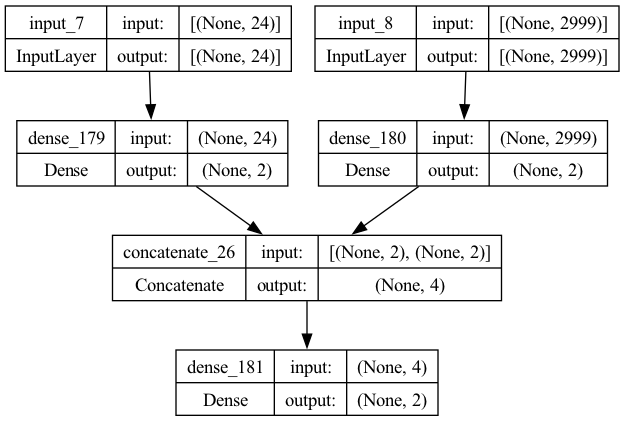

In [161]:
import keras

# Previews the network's architecture.
keras.utils.plot_model(model, show_shapes=True)


In [107]:
# Fits the model.
history = model.fit(x=[X_train_tf_mirna_seq, X_train_tf_target_seq],
                    y=y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=([X_test_tf_mirna_seq, X_test_tf_target_seq],
                                     y_test))


Epoch 1/10
3233/3233 [==============================] - 12s 3ms/step - loss: 0.5783 - accuracy: 0.6982 - val_loss: 0.5616 - val_accuracy: 0.7131
Epoch 2/10
3233/3233 [==============================] - 9s 3ms/step - loss: 0.5513 - accuracy: 0.7231 - val_loss: 0.5418 - val_accuracy: 0.7336
Epoch 3/10
3233/3233 [==============================] - 9s 3ms/step - loss: 0.5364 - accuracy: 0.7379 - val_loss: 0.5311 - val_accuracy: 0.7428
Epoch 4/10
3233/3233 [==============================] - 9s 3ms/step - loss: 0.5283 - accuracy: 0.7434 - val_loss: 0.5248 - val_accuracy: 0.7445
Epoch 5/10
3233/3233 [==============================] - 9s 3ms/step - loss: 0.5230 - accuracy: 0.7468 - val_loss: 0.5201 - val_accuracy: 0.7476
Epoch 6/10
3233/3233 [==============================] - 9s 3ms/step - loss: 0.5189 - accuracy: 0.7497 - val_loss: 0.5162 - val_accuracy: 0.7508
Epoch 7/10
3233/3233 [==============================] - 9s 3ms/step - loss: 0.5153 - accuracy: 0.7509 - val_loss: 0.5126 - val_accuracy

In [113]:
# !pip install matplotlib

In [115]:
import matplotlib.pyplot as plt

def visualize_metrics(history):
    """
        Plots the evaluation metrics generated during training.

        Parameters:
            history: History generated while training.

        Returns:
            None
    """

    # Visualizes the results.
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


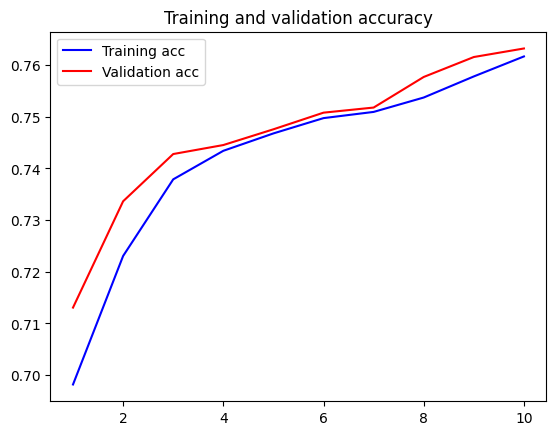

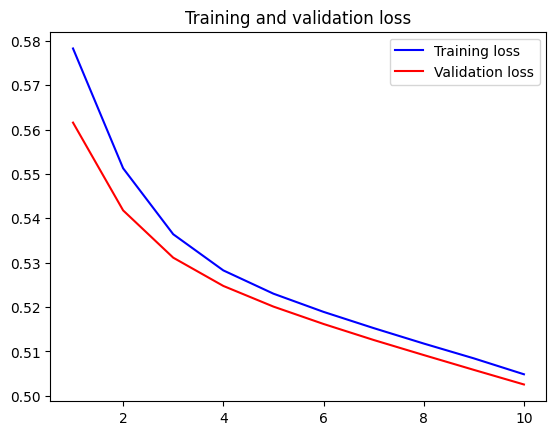

In [116]:
# Visualizes the training.
visualize_metrics(history)


The resulting model is statistically significant, with 76% accuracy; therefore, it constitutes a valid baseline for the project.

### 7. Model overfitting <a class="anchor" id="section7"></a>
After defining a baseline, the next step is to develop a model that overfits. For that purpose, the number of layers and units will be increased, alongside more epochs.


In [163]:
# Builds the branch of the network handling miRNAs.
m = Dense(1024, activation=l_relu)(mirna_seq_input)
m = Dense(512, activation=l_relu)(m)
m = Dense(256, activation=l_relu)(m)
m = Dense(128, activation=l_relu)(m)
m = Dense(64, activation=l_relu)(m)
m = Model(inputs=mirna_seq_input, outputs=m)

# Builds the part of the network handling mRNA targets.
t = Dense(1024, activation=l_relu)(target_seq_input)
t = Dense(512, activation=l_relu)(t)
t = Dense(256, activation=l_relu)(t)
t = Dense(128, activation=l_relu)(t)
t = Dense(64, activation=l_relu)(t)
t = Model(inputs=target_seq_input, outputs=t)

# Combines the outputs of both branches.
c = concatenate([m.output, t.output])

# Defines the prediction layer.
p = Dense(total_classes, activation='softmax')(c)

# Sets the model accepting multiple inputs.
model = Model(inputs=[m.input, t.input], outputs=p)

# Compiles the model
model.compile(optimizer=RMSprop(learning_rate=1e-6),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


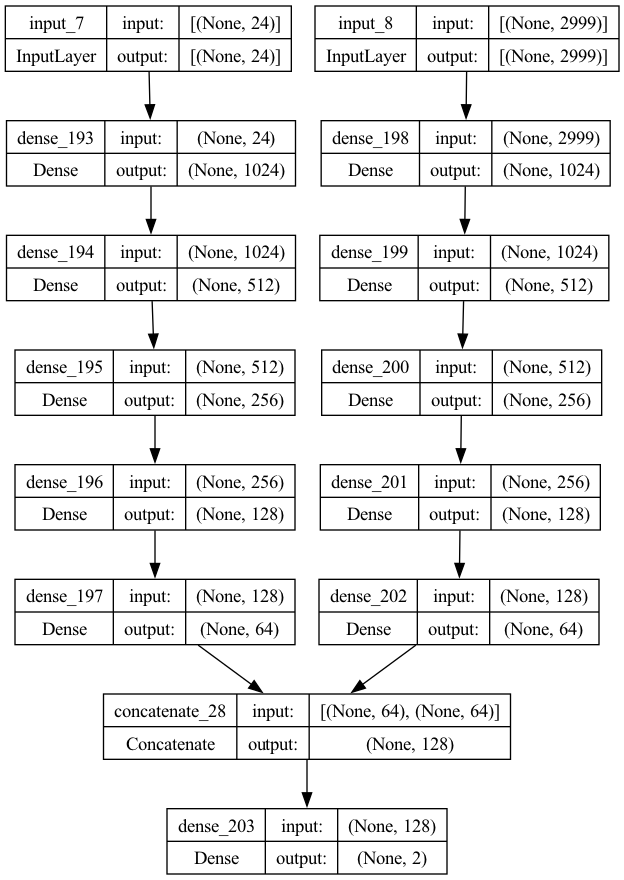

In [164]:
# Previews the network's architecture.
keras.utils.plot_model(model, show_shapes=True)


In [148]:
# Fits the model.
history = model.fit(x=[X_train_tf_mirna_seq, X_train_tf_target_seq],
                    y=y_train,
                    batch_size=256,
                    epochs=10,
                    validation_data=([X_test_tf_mirna_seq, X_test_tf_target_seq], y_test))


Epoch 1/10
405/405 [==============================] - 13s 24ms/step - loss: 0.0988 - accuracy: 0.9856 - val_loss: 0.0378 - val_accuracy: 0.9933
Epoch 2/10
405/405 [==============================] - 9s 23ms/step - loss: 0.0125 - accuracy: 0.9969 - val_loss: 0.0183 - val_accuracy: 0.9963
Epoch 3/10
405/405 [==============================] - 9s 22ms/step - loss: 0.0099 - accuracy: 0.9975 - val_loss: 0.0123 - val_accuracy: 0.9972
Epoch 4/10
405/405 [==============================] - 9s 22ms/step - loss: 0.0163 - accuracy: 0.9959 - val_loss: 0.0163 - val_accuracy: 0.9971
Epoch 5/10
405/405 [==============================] - 9s 22ms/step - loss: 0.0089 - accuracy: 0.9975 - val_loss: 0.0147 - val_accuracy: 0.9968
Epoch 6/10
405/405 [==============================] - 9s 22ms/step - loss: 0.0084 - accuracy: 0.9975 - val_loss: 0.0158 - val_accuracy: 0.9971
Epoch 7/10
405/405 [==============================] - 9s 21ms/step - loss: 0.0080 - accuracy: 0.9975 - val_loss: 0.0168 - val_accuracy: 0.997

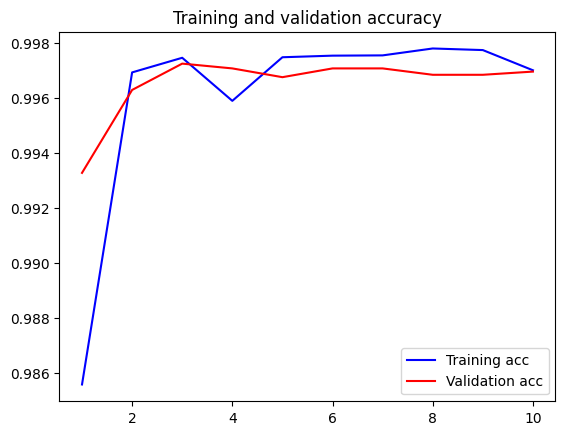

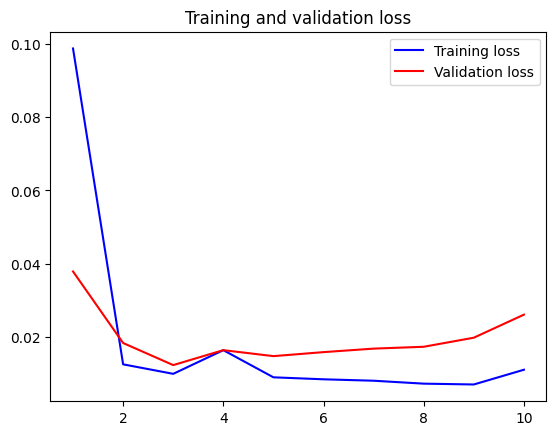

In [150]:
# Visualizes the training.
visualize_metrics(history)


The graphs show a model that overfits, with validation loss higher than the training loss, and validation accuracy lower than training accuracy.

### 8. Regularization and hyperparameter tuning <a class="anchor" id="section8"></a>
After developing a baseline and overfitting model, the model can be modified to achieve an optimal result. To reduce overfitting, the number pf layers and units were reduced. Furthermore, regularization was applied by setting L1 and L2 regularizers on the model's layers. Finally, Dropout layers were included into the network's architecture.

In [186]:
from keras.src.layers import Dropout
from keras import regularizers

# Builds the branch of the network handling miRNAs.
m = Dense(64, activation=l_relu)(mirna_seq_input)
m = Dropout(0.1)(m)
m = Dense(32,
          activation=l_relu,
          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
          bias_regularizer=regularizers.L2(1e-4),
          activity_regularizer=regularizers.L2(1e-5))(m)
m = Model(inputs=mirna_seq_input, outputs=m)

# Builds the part of the network handling mRNA targets.
t = Dense(64, activation=l_relu)(target_seq_input)
t = Dropout(0.1)(t)
t = Dense(32,
          activation=l_relu,
          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
          bias_regularizer=regularizers.L2(1e-4),
          activity_regularizer=regularizers.L2(1e-5))(t)
t = Model(inputs=target_seq_input, outputs=t)

# Combines the outputs of both branches.
c = concatenate([m.output, t.output])

# Sets a fully connected layer.
f = Dense(16, activation=l_relu)(c)
# Defines the prediction layer.
p = Dense(total_classes, activation='softmax')(f)

# Sets the model accepting multiple inputs.
model = Model(inputs=[m.input, t.input], outputs=p)

# Compiles the model
model.compile(optimizer=RMSprop(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


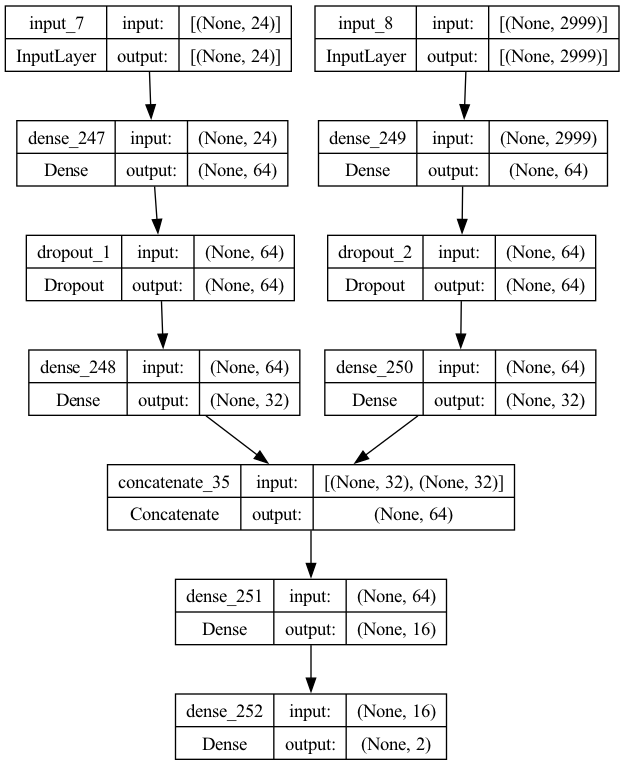

In [187]:
# Previews the network's architecture.
keras.utils.plot_model(model, show_shapes=True)


In [176]:
# Fits the model.
history = model.fit(x=[X_train_tf_mirna_seq, X_train_tf_target_seq],
                    y=y_train,
                    batch_size=64,
                    epochs=10,
                    validation_data=([X_test_tf_mirna_seq, X_test_tf_target_seq], y_test))


Epoch 1/10
1617/1617 [==============================] - 13s 7ms/step - loss: 0.4995 - accuracy: 0.7597 - val_loss: 0.3808 - val_accuracy: 0.8404
Epoch 2/10
1617/1617 [==============================] - 10s 6ms/step - loss: 0.3127 - accuracy: 0.8836 - val_loss: 0.2576 - val_accuracy: 0.9210
Epoch 3/10
1617/1617 [==============================] - 9s 6ms/step - loss: 0.2120 - accuracy: 0.9396 - val_loss: 0.1782 - val_accuracy: 0.9523
Epoch 4/10
1617/1617 [==============================] - 9s 6ms/step - loss: 0.1496 - accuracy: 0.9593 - val_loss: 0.1308 - val_accuracy: 0.9633
Epoch 5/10
1617/1617 [==============================] - 9s 5ms/step - loss: 0.1118 - accuracy: 0.9691 - val_loss: 0.1014 - val_accuracy: 0.9717
Epoch 6/10
1617/1617 [==============================] - 9s 6ms/step - loss: 0.0879 - accuracy: 0.9764 - val_loss: 0.0820 - val_accuracy: 0.9771
Epoch 7/10
1617/1617 [==============================] - 9s 6ms/step - loss: 0.0714 - accuracy: 0.9808 - val_loss: 0.0686 - val_accurac

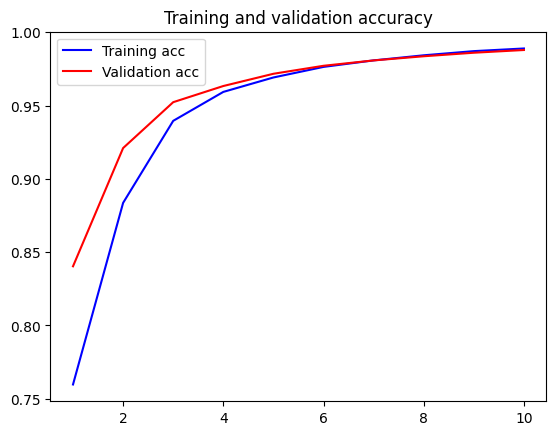

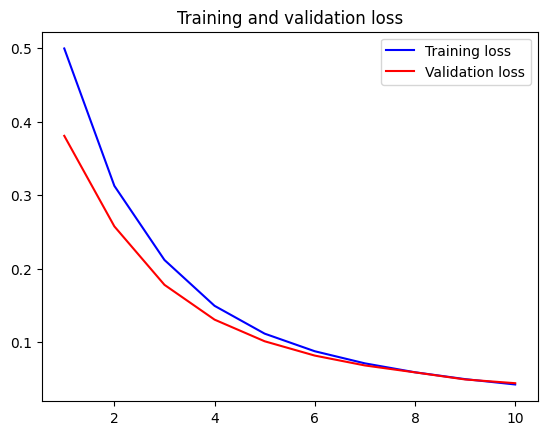

In [177]:
# Visualizes the training.
visualize_metrics(history)


The results show a network successfully trained and able to generalize when exposed to new data. The <b>resulting accuracy of the network is 98%</b>.

### 8. Conclusions <a class="anchor" id="section8"></a>
This project proved a new methodology for expanding and fit current miRNA-target datasets to other organisms, while handling the lack of negative examples. Since lack of negative examples is a major concern limiting the development of Deep Neural Networks able to predict the molecular interactions, the processes exposed in this research are highly valuable.

The study also proved that a deep neural approach is suitable for miRNA-target prediction, achieving an overall accuracy of 98% and 0.0004 loss.

### References <a class="anchor" id="references"></a>

[1] A. Pla, X. Zhong, and S. Rayner, “miRAW: A deep learning-based approach to predict microRNA targets by analyzing whole microRNA transcripts,” PLOS Computational Biology, vol. 14, no. 7, p. e1006185, Jul. 2018, doi: 10.1371/journal.pcbi.1006185.

[2] J. O’Brien, H. Hayder, Y. Zayed, and C. Peng, “Overview of MicroRNA Biogenesis, Mechanisms of Actions, and Circulation,” Frontiers in Endocrinology, vol. 9, 2018, Accessed: May 04, 2023. [Online]. Available: https://www.frontiersin.org/articles/10.3389/fendo.2018.00402

[3] A. Quillet et al., “Improving Bioinformatics Prediction of microRNA Targets by Ranks Aggregation,” Frontiers in Genetics, vol. 10, 2020, Accessed: May 04, 2023. [Online]. Available: https://www.frontiersin.org/articles/10.3389/fgene.2019.01330

[4] H. Nakayashiki, ‘RNA silencing in fungi: Mechanisms and applications’, FEBS Letters, vol. 579, no. 26, pp. 5950–5957, Oct. 2005, doi: 10.1016/j.febslet.2005.08.016.

[5] T. Kakati, D. K. Bhattacharyya, J. K. Kalita, and T. M. Norden-Krichmar, ‘DEGnext: classification of differentially expressed genes from RNA-seq data using a convolutional neural network with transfer learning’, BMC Bioinformatics, vol. 23, no. 1, p. 17, Jan. 2022, doi: 10.1186/s12859-021-04527-4.

[6] B. Hanczar, F. Zehraoui, T. Issa, and M. Arles, ‘Biological interpretation of deep neural network for phenotype prediction based on gene expression’, BMC Bioinformatics, vol. 21, no. 1, p. 501, Nov. 2020, doi: 10.1186/s12859-020-03836-4.

[7] D. Urda, J. Montes-Torres, F. Moreno, L. Franco, and J. M. Jerez, ‘Deep Learning to Analyze RNA-Seq Gene Expression Data’, in Advances in Computational Intelligence, I. Rojas, G. Joya, and A. Catala, Eds., in Lecture Notes in Computer Science, vol. 10306. Cham: Springer International Publishing, 2017, pp. 50–59. doi: 10.1007/978-3-319-59147-6_5.

[8] ‘Central Dogma’, Genome.gov, Sep. 14, 2022. https://www.genome.gov/genetics-glossary/Central-Dogma (accessed May 07, 2023).

[9] A. Talukder, W. Zhang, X. Li, and H. Hu, “A deep learning method for miRNA/isomiR target detection,” Sci Rep, vol. 12, no. 1, Art. no. 1, Jun. 2022, doi: 10.1038/s41598-022-14890-8.

[10] O. P. Gupta, P. Sharma, R. K. Gupta, and I. Sharma, “Current status on role of miRNAs during plant–fungus interaction,” Physiological and Molecular Plant Pathology, vol. 85, pp. 1–7, Jan. 2014, doi: 10.1016/j.pmpp.2013.10.002.

[11] E. Marín-González and P. Suárez-López, “‘And yet it moves’: Cell-to-cell and long-distance signaling by plant microRNAs,” Plant Science, vol. 196, pp. 18–30, Nov. 2012, doi: 10.1016/j.plantsci.2012.07.009.

[12] T. Siddika and I. U. Heinemann, “Bringing MicroRNAs to Light: Methods for MicroRNA Quantification and Visualization in Live Cells,” Frontiers in Bioengineering and Biotechnology, vol. 8, 2021, Accessed: Apr. 18, 2023. [Online]. Available: https://www.frontiersin.org/articles/10.3389/fbioe.2020.619583

[13] J. K. W. Lam, M. Y. T. Chow, Y. Zhang, and S. W. S. Leung, “siRNA Versus miRNA as Therapeutics for Gene Silencing,” Mol Ther Nucleic Acids, vol. 4, no. 9, p. e252, Sep. 2015, doi: 10.1038/mtna.2015.23.

[14] “miRTarBase: the experimentally validated microRNA-target interactions database.” https://mirtarbase.cuhk.edu.cn/~miRTarBase/miRTarBase_2022/php/index.php (accessed May 08, 2023).

[15] “Gene Regulation,” Genome.gov, Sep. 14, 2022. https://www.genome.gov/genetics-glossary/Gene-Regulation (accessed May 09, 2023).

[16] C. Stylianopoulou, “Carbohydrates: Regulation of metabolism,” in Encyclopedia of Human Nutrition (Fourth Edition), B. Caballero, Ed., Oxford: Academic Press, 2023, pp. 126–135. doi: 10.1016/B978-0-12-821848-8.00173-6.

[17] L. He and G. J. Hannon, “MicroRNAs: small RNAs with a big role in gene regulation,” Nat Rev Genet, vol. 5, no. 7, Art. no. 7, Jul. 2004, doi: 10.1038/nrg1379.

[18] D. Pradhan, A. Kumar, H. Singh, and U. Agrawal, “Chapter 4 - High-throughput sequencing,” in Data Processing Handbook for Complex Biological Data Sources, G. Misra, Ed., Academic Press, 2019, pp. 39–52. doi: 10.1016/B978-0-12-816548-5.00004-6.

[19] B. Hanczar, F. Zehraoui, T. Issa, and M. Arles, “Biological interpretation of deep neural network for phenotype prediction based on gene expression,” BMC Bioinformatics, vol. 21, no. 1, p. 501, Nov. 2020, doi: 10.1186/s12859-020-03836-4.

[20] A. L. Leitão and F. J. Enguita, “A Structural View of miRNA Biogenesis and Function,” Non-Coding RNA, vol. 8, no. 1, Art. no. 1, Feb. 2022, doi: 10.3390/ncrna8010010.

[21] ‘Gene Expression | Learn Science at Scitable’. https://www.nature.com/scitable/topicpage/gene-expression-14121669/ (accessed May 07, 2023).

[22] W. Guo, Y. Xu, and X. Feng, ‘DeepMetabolism: A Deep Learning System to Predict Phenotype from Genome Sequencing’. arXiv, May 08, 2017. doi: 10.48550/arXiv.1705.03094.

[23] M. Wen, P. Cong, Z. Zhang, H. Lu, and T. Li, ‘DeepMirTar: a deep-learning approach for predicting human miRNA targets’, Bioinformatics, vol. 34, no. 22, pp. 3781–3787, Nov. 2018, doi: 10.1093/bioinformatics/bty424.

[24] X. M. Xu and S. G. Møller, ‘The value of Arabidopsis research in understanding human disease states’, Curr Opin Biotechnol, vol. 22, no. 2, pp. 300–307, Apr. 2011, doi: 10.1016/j.copbio.2010.11.007.

[25] G. P. Way and C. S. Greene, ‘Extracting a Biologically Relevant Latent Space from Cancer Transcriptomes with Variational Autoencoders’. bioRxiv, p. 174474, Aug. 11, 2017. doi: 10.1101/174474.

[26] J. Rocca, ‘Understanding Variational Autoencoders (VAEs)’, Medium, Mar. 21, 2021. https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73 (accessed Jun. 07, 2023).

[27] C. H. Grønbech, M. F. Vording, P. Timshel, C. K. Sønderby, T. H. Pers, and O. Winther, ‘scVAE: Variational auto-encoders for single-cell gene expression data’. bioRxiv, p. 318295, Oct. 02, 2019. doi: 10.1101/318295.

[28] K. Y. Gao, A. Fokoue, H. Luo, A. Iyengar, S. Dey, and P. Zhang, ‘Interpretable Drug Target Prediction Using Deep Neural Representation’, in Proceedings of the Twenty-Seventh International Joint Conference on Artificial Intelligence, Stockholm, Sweden: International Joint Conferences on Artificial Intelligence Organization, Jul. 2018, pp. 3371–3377. doi: 10.24963/ijcai.2018/468.

[29] ‘Arabidopsis thaliana (ID 4) - Genome - NCBI’. https://www.ncbi.nlm.nih.gov/genome/4?genome_assembly_id=380024 (accessed Jul. 02, 2023).

[30] G. B. Or and I. Veksler-Lublinsky, ‘Comprehensive machine-learning-based analysis of microRNA-target interactions reveals variable transferability of interaction rules across species’. bioRxiv, p. 2021.03.28.437385, Mar. 29, 2021. doi: 10.1101/2021.03.28.437385.

[31] ‘Arabidopsis thaliana (ID 4) - Genome - NCBI’. https://www.ncbi.nlm.nih.gov/genome/4?genome_assembly_id=380024 (accessed Jul. 02, 2023).

[32] X. Chen, ‘Small RNAs – secrets and surprises of the genome’, Plant J, vol. 61, no. 6, pp. 941–958, Mar. 2010, doi: 10.1111/j.1365-313X.2009.04089.x.

[33] S. Bandyopadhyay and R. Mitra, ‘TargetMiner: microRNA target prediction with systematic identification of tissue-specific negative examples’, Bioinformatics, vol. 25, no. 20, pp. 2625–2631, Oct. 2009, doi: 10.1093/bioinformatics/btp503.

[34] ‘PmiREN: Plant microRNA Encyclopedia’. https://www.pmiren.com/download (accessed Aug. 04, 2023).

[35] ‘refSeq Accession to Gene Symbol Converter - Genomics Biotools’. https://www.biotools.fr/mouse/refseq_symbol_converter (accessed Aug. 07, 2023).

[36] ‘miRBase - Downloads’. https://mirbase.org/download/ (accessed Aug. 13, 2023).

[37] ‘Genome’, NCBI. https://www.ncbi.nlm.nih.gov/datasets/genome/?taxon=9606 (accessed Aug. 13, 2023).

[38] ‘11968211 - Assembly - NCBI’. https://www.ncbi.nlm.nih.gov/assembly/?term=GCF_000001405 (accessed Aug. 13, 2023).

[39] B. Murcott, R. J. Pawluk, A. V. Protasio, R. Y. Akinmusola, D. Lastik, and V. L. Hunt, ‘stepRNA: Identification of Dicer cleavage signatures and passenger strand lengths in small RNA sequences’, Frontiers in Bioinformatics, vol. 2, 2022, Accessed: Aug. 18, 2023. [Online].

[40] H.-Y. Huang et al., ‘miRTarBase update 2022: an informative resource for experimentally validated miRNA–target interactions’, Nucleic Acids Research, vol. 50, no. D1, pp. D222–D230, Jan. 2022, doi: 10.1093/nar/gkab1079.

[41] ‘Bio.pairwise2 module — Biopython 1.75 documentation’. https://biopython.org/docs/1.75/api/Bio.pairwise2.html (accessed Aug. 29, 2023).

[42] ‘miRBase’. https://www.mirbase.org/ftp.shtml (accessed May 08, 2023).

[43] ‘TAIR - Home Page’. https://www.arabidopsis.org/index.jsp (accessed Sep. 07, 2023).

[44] ‘Home - Nucleotide - NCBI’. https://www.ncbi.nlm.nih.gov/nuccore/ (accessed Sep. 20, 2023).

[45] ‘Average gene length - Thale cress Arabidopsis thalia - BNID 105370’. https://bionumbers.hms.harvard.edu/bionumber.aspx?id=105370&ver=0 (accessed Sep. 22, 2023).

[46] ‘Chapter 6. Deep learning for text and sequences · Deep Learning with Python’. https://livebook.manning.com/book/deep-learning-with-python/chapter-4/ (accessed Sep. 24, 2023).

[47] ‘Chapter 4. Fundamentals of machine learning · Deep Learning with Python’. https://livebook.manning.com/book/deep-learning-with-python/chapter-4/ (accessed Sep. 24, 2023).

[48] A. Rosebrock, ‘Keras: Multiple Inputs and Mixed Data’, PyImageSearch, Feb. 04, 2019. https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/ (accessed Sep. 25, 2023).

[49] soma.basu@imerit.net, “Working on an AI Project? Here’s How Much Data You’ll Need.,” iMerit, Oct. 08, 2021. https://imerit.net/blog/how-much-data-do-you-need-for-your-ai-ml-project-all-pbm/ (accessed Mar. 12, 2023).

[50] “Chapter 4. Fundamentals of machine learning · Deep Learning with Python.” https://livebook.manning.com/book/deep-learning-with-python/chapter-4/ (accessed Mar. 12, 2023).
